In [29]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import pickle

In [31]:
traindf = pd.read_csv("train_Df64byy.csv")
testdf = pd.read_csv("test_YCcRunU.csv")

In [32]:
df = pd.concat([traindf,testdf],axis=0)
ID_complete = df.ID
testindex = traindf.shape[0]

Let us first check the missing values per column. Note that there might be columns where the missing value might not get detected. 

In [33]:
#Changing Health Indicator to Health_Indicator so we can use df.col notation easily
df.columns = ['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health_Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response']

In [34]:
print(df.isna().sum())

catcols = ['City_Code','Region_Code','Is_Spouse','Accomodation_Type','Reco_Insurance_Type','Health_Indicator','Holding_Policy_Type','Reco_Policy_Cat']
for col in catcols:
    print('--------------------{}------------------\n'.format(col))
    print(df[col].unique())
    print('------------------------------------------------\n')

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health_Indicator           16718
Holding_Policy_Duration    28854
Holding_Policy_Type        28854
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                   21805
dtype: int64
--------------------City_Code------------------

['C3' 'C5' 'C24' 'C8' 'C9' 'C1' 'C15' 'C28' 'C27' 'C7' 'C20' 'C25' 'C4'
 'C2' 'C34' 'C10' 'C17' 'C18' 'C16' 'C29' 'C33' 'C26' 'C19' 'C6' 'C12'
 'C13' 'C11' 'C14' 'C22' 'C23' 'C21' 'C36' 'C32' 'C30' 'C35' 'C31']
------------------------------------------------

--------------------Region_Code------------------

[3213 1117 3732 ... 5783 5961 5902]
------------------------------------------------

--------------------Is_Spouse------------------

['No' 'Yes']
----------------

As seen above, among the categorical variables only `Health_Indicator` & `Holding_Policy_Type` have miissing values. Let's check the numerical columns

In [35]:
numcols =  ['Upper_Age','Lower_Age','Holding_Policy_Duration','Reco_Policy_Premium']

#As seen when we called df.head, Holding_Policy_Duration requires some cleanup

print('Unique values in Holding_Policy_Duration column : {}'.format(df.Holding_Policy_Duration.unique()))

# So only 14+ column is causing problem. We can safely replace 14+ with 14. Note this will be the most conservative assumption among the set of assumptions we can make

df.Holding_Policy_Duration.replace("14+",14,inplace=True)

Unique values in Holding_Policy_Duration column : ['14+' nan '1.0' '3.0' '5.0' '9.0' '14.0' '7.0' '2.0' '11.0' '10.0' '8.0'
 '6.0' '4.0' '13.0' '12.0']


## Missing Value Treatment ##


Now we have to replace missing valeus in the 3 columns : `Health_Indicator`, `Holding_Policy_Duration` & `Holding_Policy_Type`. First I want to look at `Holding_Policy_Type` & `Holding_Policy_Duration`. A missing value in this column might indicate that a particular person does not hold any policy. If this assumption is true, then `Holding_Policy_Duration` should also by `NaN`

In [36]:
print('Unique values in Holding_Policy_Duration given that Holding_Policy_Type is missing : {}\n'
      .format(df.Holding_Policy_Duration[df.Holding_Policy_Type.isna()].unique()))

## Thus it is confirmed that the missing values in Holding_Policy_Duration are not Missing at Random. Let us check if converse is true as well

print('Unique values in Holding_Policy_Type given that Holding_Policy_Duration is missing : {}\n'.
      format(df.Holding_Policy_Type[df.Holding_Policy_Duration.isna()].unique()))

#The converse is true as well.

Unique values in Holding_Policy_Duration given that Holding_Policy_Type is missing : [nan]

Unique values in Holding_Policy_Type given that Holding_Policy_Duration is missing : [nan]



As seen above the missing values in `Holding_Policy_Type` & `Holding_Policy_Duration` are not Missing Completely at Random (MCAR). They are infact a result of given person not holding any policy in past. So I'll replace missing value sin `Holding_Policy_Type` & `Holding_Policy_Duration` with -999. Before, I do that, I'll make a quick check if the missing values form a majority of the column values. In that case, we might be better off removing the columns

In [37]:
print('Missing value perc in Holding_Policy_Type column : {}'.format(df.Holding_Policy_Type.isna().sum()/df.shape[0]))
print('Missing value perc in Holding_Policy_Duration column : {}'.format(df.Holding_Policy_Duration.isna().sum()/df.shape[0]))

# Alrigh 40% missing value mean that 60% of the data is filled and is thus useful for us
df.Holding_Policy_Type.fillna(-1,inplace=True)
df.Holding_Policy_Duration.fillna(-1,inplace=True)

Missing value perc in Holding_Policy_Type column : 0.396962317883528
Missing value perc in Holding_Policy_Duration column : 0.396962317883528


Moving on to `Health_Indicator`. Let us see percentage missing in this column 

In [38]:
print('Missing value perc in Health_Indicator column : {}'.format(df.Health_Indicator.isna().sum()/df.shape[0]))

# ~23% missing, proceeding to see if there is any connection with the two other columns we just imputed 

Missing value perc in Health_Indicator column : 0.22999986242381718


In [39]:
#Imputing Health_Indicator with -1
df.Health_Indicator.fillna('X0',inplace=True)

In [40]:
#Checking column types and correcting them as required
df.Region_Code = df.Region_Code.astype(str)
df.Holding_Policy_Duration = df.Holding_Policy_Duration.astype(float).astype(int)
df.Holding_Policy_Type = df.Holding_Policy_Type.astype(str)
df.Reco_Policy_Cat = df.Reco_Policy_Cat.astype(str)


#As we have been explicitly asked to not use IDs for modelling, dropping them
df = df.drop(columns = ['ID'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72687 entries, 0 to 21804
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                72687 non-null  object 
 1   Region_Code              72687 non-null  object 
 2   Accomodation_Type        72687 non-null  object 
 3   Reco_Insurance_Type      72687 non-null  object 
 4   Upper_Age                72687 non-null  int64  
 5   Lower_Age                72687 non-null  int64  
 6   Is_Spouse                72687 non-null  object 
 7   Health_Indicator         72687 non-null  object 
 8   Holding_Policy_Duration  72687 non-null  int32  
 9   Holding_Policy_Type      72687 non-null  object 
 10  Reco_Policy_Cat          72687 non-null  object 
 11  Reco_Policy_Premium      72687 non-null  float64
 12  Response                 50882 non-null  float64
dtypes: float64(2), int32(1), int64(2), object(8)
memory usage: 7.5+ MB


In [41]:
traindf = df.iloc[:testindex,:]

## Data Visualization ##

0.0    0.760053
1.0    0.239947
Name: Response, dtype: float64

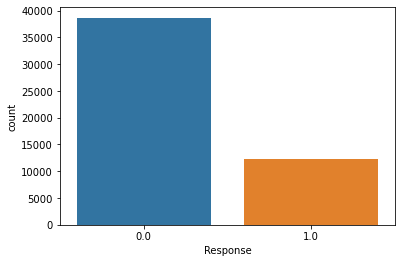

In [13]:
#First let us see the distribution of target variable
sns.countplot(x=traindf.Response)
traindf.Response.value_counts()/traindf.shape[0]

The target variable is imbalanced. Approximately 76% of the leads end up in no response. This provides a baseline metric for modelling. Any model showing less that 76% accuracy is useless.

<AxesSubplot:>

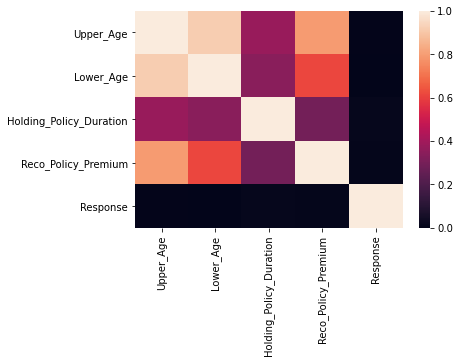

In [14]:
sns.heatmap(traindf.corr())

Seems like the response variable has very low correlation with the numerical columns

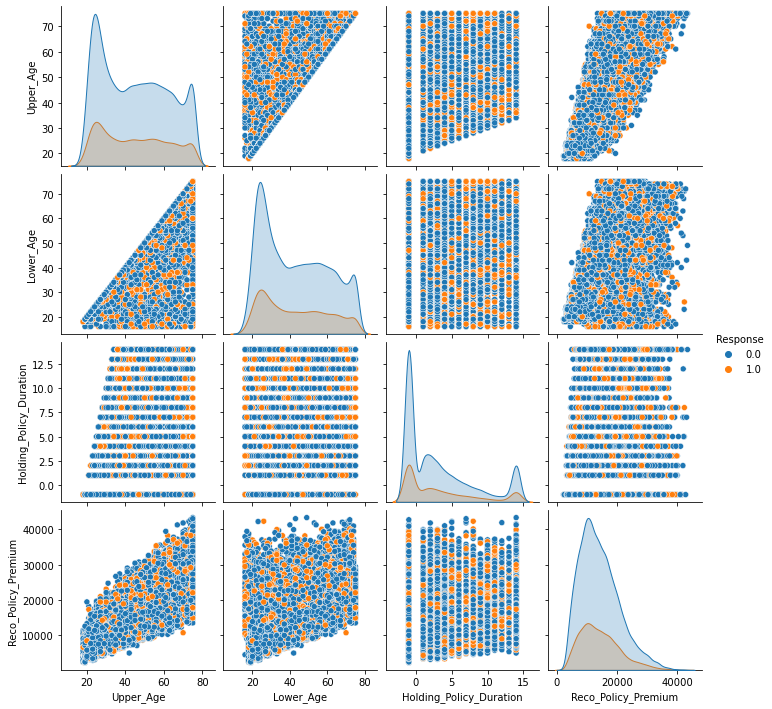

In [94]:
sns.pairplot(traindf,hue="Response")

There is no clear boundary separating target variables, This was a logical conclusion from the correlation plot but it's good to have a double check on this. This tells us that the categorical variables will be playing a key role in the model we build.

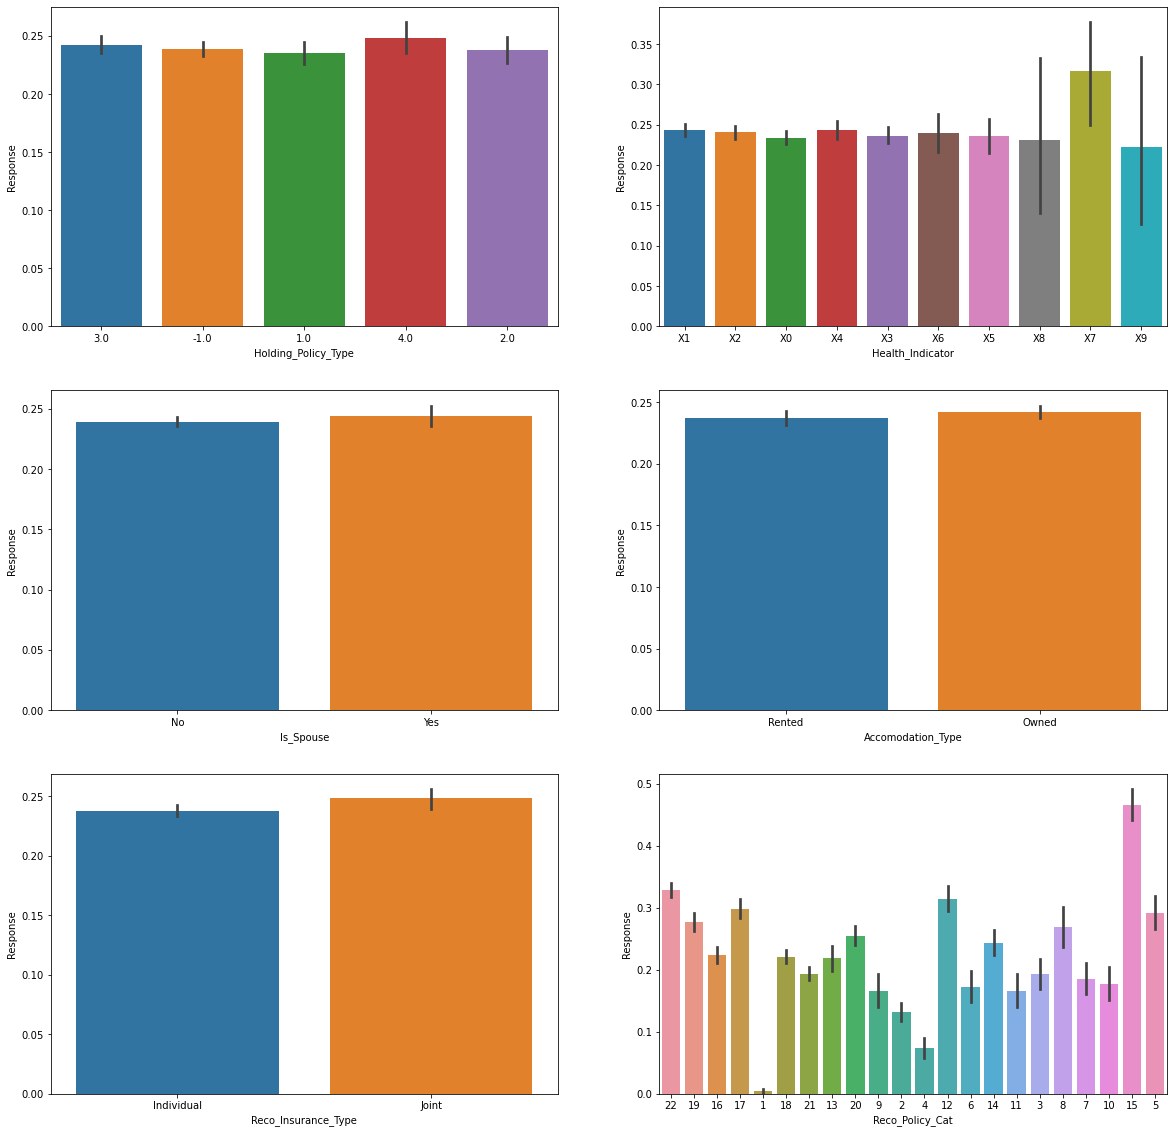

In [95]:
fig, axes = plt.subplots(3,2,figsize=(20, 20))
sns.barplot(ax=axes[0,0],y='Response',x="Holding_Policy_Type",data=traindf)
sns.barplot(ax=axes[0,1],y='Response',x="Health_Indicator",data=traindf)
sns.barplot(ax=axes[1,0],y='Response',x="Is_Spouse",data=traindf)
sns.barplot(ax=axes[1,1],y='Response',x="Accomodation_Type",data=traindf)
sns.barplot(ax=axes[2,0],y='Response',x="Reco_Insurance_Type",data=traindf)
sns.barplot(ax=axes[2,1],y='Response',x="Reco_Policy_Cat",data=traindf)

plt.show()

This has some interesting insights : 
<ol>
    <li> `Health_Indicator` category X7 has highest success rate </li>
    <li> `Reco_Policy_Cat` category 15 has highest success rate </li>
    <li> `Reco_Category_Cat` category 1,4 have highest failure rate </li>
    <li> Variables like `Is_Spouse`, `Accomodation_Typ` and `Reco_Insurance_Type` are not very useful in predicting response variable </li>
 

In [15]:
traindf.columns


Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health_Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium', 'Response'],
      dtype='object')

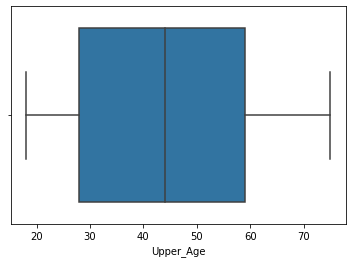

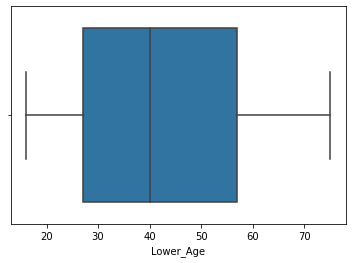

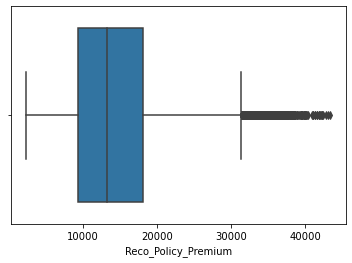

In [16]:
numcols =['Upper_Age','Lower_Age','Reco_Policy_Premium']
for i in numcols:
    plt.figure()
    sns.boxplot(x=traindf[i])

So the Policy Premium bit has quite a few outliers, let us dig little deeper into this

In [42]:
traindf.Reco_Policy_Premium.describe()

count    50882.000000
mean     14183.950069
std       6590.074873
min       2280.000000
25%       9248.000000
50%      13178.000000
75%      18096.000000
max      43350.400000
Name: Reco_Policy_Premium, dtype: float64

In [43]:
# I'll convert the Reco_Poliy_Premium to logarithmic scale. Note, I'm doing this for the whole data (train+test)
df.Reco_Policy_Premium = np.log(df.Reco_Policy_Premium)

## Feature Engineering ##
Removed features not used in final model

In [44]:
df.head()

City_Code Region_Code Accomodation_Type Reco_Insurance_Type  Upper_Age  \
0        C3        3213            Rented          Individual         36   
1        C5        1117             Owned               Joint         75   
2        C5        3732             Owned          Individual         32   
3       C24        4378             Owned               Joint         52   
4        C8        2190            Rented          Individual         44   

   Lower_Age Is_Spouse Health_Indicator  Holding_Policy_Duration  \
0         36        No               X1                       14   
1         22        No               X2                       -1   
2         32        No               X0                        1   
3         48        No               X1                       14   
4         44        No               X2                        3   

  Holding_Policy_Type Reco_Policy_Cat  Reco_Policy_Premium  Response  
0                 3.0              22             9.361171       0.0  
1                -1.0              22            10.325810       0.0  
2                 1.0              19             8.915969       1.0  
3                 3.0              19             9.785830       0.0  
4                 1.0              16             9.249946       0.0

In [45]:
df['Average_Age'] = (df.Upper_Age + df.Lower_Age)/2
df['Premium_per_Age'] = df.Reco_Policy_Premium/df.Average_Age

In [46]:
# ## Adding Frequency Encoding

# freq_City_Code = (df.groupby('City_Code').size()) / len(df)
# df['City_Code_Freq'] = df['City_Code'].apply(lambda x : freq_City_Code[x])

# freq_Accomodation_Type = (df.groupby('Accomodation_Type').size()) / len(df)
# df['Accomodation_Type_Freq'] = df['Accomodation_Type'].apply(lambda x : freq_Accomodation_Type[x])

# freq_Reco_Insurance_Type = (df.groupby('Reco_Insurance_Type').size()) / len(df)
# df['Reco_Insurance_Type_Freq'] = df['Reco_Insurance_Type'].apply(lambda x : freq_Reco_Insurance_Type[x])

# freq_Holding_Policy_Type = (df.groupby('Holding_Policy_Type').size()) / len(df)
# df['Holding_Policy_Type_Freq'] = df['Holding_Policy_Type'].apply(lambda x : freq_Holding_Policy_Type[x])

# freq_Health_Indicator = (df.groupby('Health_Indicator').size())/ len(df)
# df['Health_Indicator_Freq'] = df['Health_Indicator'].apply(lambda x : freq_Health_Indicator[x])

# freq_Reco_Policy_Cat = (df.groupby('Reco_Policy_Cat').size()) / len(df)
# df['Reco_Policy_Cat_Freq'] = df['Reco_Policy_Cat'].apply(lambda x : freq_Reco_Policy_Cat[x])

# freq_Region_Code = (df.groupby('Region_Code').size()) / len(df)
# df['Region_Code_Freq'] = df['Region_Code'].apply(lambda x : freq_Region_Code[x])

# freq_Is_Spouse = (df.groupby('Is_Spouse').size()) / len(df)
# df['Is_Spouse_Freq'] = df['Is_Spouse'].apply(lambda x : freq_Is_Spouse[x])

# for i in rangelen(catcols)-1):
#     new_feature_name =catcols[i] +"_"+catcols[i+1]
#     df[new_feature_name] = df.loc[:,catcols[i]] +"_"+df.loc[:,catcols[i+1]]
    

In [47]:
#df = df.drop(columns="Region_Code")

In [61]:
catcols = ['City_Code','Region_Code',
 'Is_Spouse',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Health_Indicator',
 'Holding_Policy_Type',
 'Reco_Policy_Cat']

In [62]:
# Separating complete data into Train and Test for modelling
traindf = df.iloc[:testindex,:]
testdf = df.iloc[testindex:,:]

In [71]:
# Using 5 fold stratified cross validation.

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=None)
feature_set = ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type','Region_Code',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health_Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium']#, 'Average_Age', 'Premium_per_Age']
target = 'Response' 

X = traindf.loc[:,feature_set] # Dataset with just features
y = traindf.loc[:,target]

In [72]:
## Loop to calculate roc on each of the folds. I calculate both Logloss and AUC 
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
model = CatBoostClassifier(
    custom_metric=['Logloss','AUC:hints=skip_train~false'],
    random_seed=42,
    logging_level='Silent'
)
best_auc = 0
for train_index, test_index in skf.split(X,y): 
    X_train, X_valid = X.loc[train_index,:], X.loc[test_index,:] 
    y_train, y_valid = y[train_index], y[test_index]
    model.fit(
        X_train, y_train,
        cat_features=catcols,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=10,
        use_best_model=True,
        verbose=False,plot=True)
    score= metrics.roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])

#Initial results show we reach aroudn 0.80 AUC score in cross val    

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### GRID Search ####
Using grid search to finalize hyperparameters for the model. Aim is to get a better leaderboard score

In [60]:
model = CatBoostClassifier(
    custom_metric=['Logloss','AUC:hints=skip_train~false'],
    random_seed=42,
    cat_features=catcols,
    early_stopping_rounds=10
)

In [34]:
param_grid = {'depth':[3,6,4,10,12],
          'learning_rate':[0.03,0.01,0.10], 
          'l2_leaf_reg':[3,1,5,10],
          }

In [62]:
grid_search_result = model.grid_search(param_grid, 
                                       X=X, 
                                       y=y, 
                                       plot=True,
                                      stratified=True,
                                      calc_cv_statistics=True,
                                       search_by_train_test_split=True,
                                       refit=True,
                                       shuffle=True,
                                       train_size=0.8,
                                       verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4389377693
bestIteration = 591

0:	loss: 0.4389378	best: 0.4389378 (0)	total: 34.6s	remaining: 27m 4s

bestTest = 0.4401176395
bestIteration = 999

1:	loss: 0.4401176	best: 0.4389378 (0)	total: 1m 26s	remaining: 33m 20s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4384916575
bestIteration = 150

2:	loss: 0.4384917	best: 0.4384917 (2)	total: 1m 37s	remaining: 24m 26s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4384937294
bestIteration = 551

3:	loss: 0.4384937	best: 0.4384917 (2)	total: 2m 7s	remaining: 23m 23s

bestTest = 0.4403466824
bestIteration = 999

4:	loss: 0.4403467	best: 0.4384917 (2)	total: 3m 1s	remaining: 26m
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.43886693
bestIteration = 164

5:	loss: 0.4388669	best: 0.4384917 (2)	total: 3m 9s	remaining: 22m 3s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4388400954
bestItera

In [67]:
#Training final model with complete data + tuned hyperparameters

model = CatBoostClassifier(
    custom_metric=['AUC:hints=skip_train~false'],
    random_state=42,
    cat_features=catcols,
    depth=10,
    l2_leaf_reg=1,
    learning_rate=0.01,
)
model.fit(X, y,early_stopping_rounds=10,plot=True,verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6888153	total: 301ms	remaining: 5m
1:	learn: 0.6849853	total: 500ms	remaining: 4m 9s
2:	learn: 0.6813438	total: 672ms	remaining: 3m 43s
3:	learn: 0.6773976	total: 929ms	remaining: 3m 51s
4:	learn: 0.6742882	total: 986ms	remaining: 3m 16s
5:	learn: 0.6707218	total: 1.31s	remaining: 3m 36s
6:	learn: 0.6669675	total: 1.59s	remaining: 3m 45s
7:	learn: 0.6637685	total: 1.68s	remaining: 3m 28s
8:	learn: 0.6604053	total: 1.92s	remaining: 3m 31s
9:	learn: 0.6570878	total: 2.1s	remaining: 3m 27s
10:	learn: 0.6540717	total: 2.27s	remaining: 3m 24s
11:	learn: 0.6512307	total: 2.35s	remaining: 3m 13s
12:	learn: 0.6480270	total: 2.55s	remaining: 3m 13s
13:	learn: 0.6450104	total: 2.74s	remaining: 3m 12s
14:	learn: 0.6420288	total: 3s	remaining: 3m 17s
15:	learn: 0.6390416	total: 3.23s	remaining: 3m 18s
16:	learn: 0.6361515	total: 3.43s	remaining: 3m 18s
17:	learn: 0.6332213	total: 3.66s	remaining: 3m 19s
18:	learn: 0.6306985	total: 3.85s	remaining: 3m 18s
19:	learn: 0.6281943	total: 4.1

159:	learn: 0.4623445	total: 30.9s	remaining: 2m 42s
160:	learn: 0.4619235	total: 31.1s	remaining: 2m 42s
161:	learn: 0.4614859	total: 31.3s	remaining: 2m 42s
162:	learn: 0.4611009	total: 31.5s	remaining: 2m 41s
163:	learn: 0.4606650	total: 31.7s	remaining: 2m 41s
164:	learn: 0.4602081	total: 32s	remaining: 2m 41s
165:	learn: 0.4597724	total: 32.2s	remaining: 2m 41s
166:	learn: 0.4592771	total: 32.4s	remaining: 2m 41s
167:	learn: 0.4588193	total: 32.6s	remaining: 2m 41s
168:	learn: 0.4584783	total: 32.8s	remaining: 2m 41s
169:	learn: 0.4580951	total: 33.1s	remaining: 2m 41s
170:	learn: 0.4580647	total: 33.1s	remaining: 2m 40s
171:	learn: 0.4576379	total: 33.3s	remaining: 2m 40s
172:	learn: 0.4572979	total: 33.6s	remaining: 2m 40s
173:	learn: 0.4568840	total: 33.8s	remaining: 2m 40s
174:	learn: 0.4565186	total: 34s	remaining: 2m 40s
175:	learn: 0.4561887	total: 34.2s	remaining: 2m 40s
176:	learn: 0.4558356	total: 34.4s	remaining: 2m 40s
177:	learn: 0.4554503	total: 34.7s	remaining: 2m 4

315:	learn: 0.4310792	total: 1m 5s	remaining: 2m 21s
316:	learn: 0.4309321	total: 1m 5s	remaining: 2m 21s
317:	learn: 0.4307896	total: 1m 5s	remaining: 2m 21s
318:	learn: 0.4306039	total: 1m 6s	remaining: 2m 21s
319:	learn: 0.4305049	total: 1m 6s	remaining: 2m 20s
320:	learn: 0.4303518	total: 1m 6s	remaining: 2m 20s
321:	learn: 0.4302788	total: 1m 6s	remaining: 2m 20s
322:	learn: 0.4301762	total: 1m 7s	remaining: 2m 20s
323:	learn: 0.4300592	total: 1m 7s	remaining: 2m 20s
324:	learn: 0.4299482	total: 1m 7s	remaining: 2m 20s
325:	learn: 0.4297665	total: 1m 7s	remaining: 2m 20s
326:	learn: 0.4296912	total: 1m 8s	remaining: 2m 19s
327:	learn: 0.4295991	total: 1m 8s	remaining: 2m 19s
328:	learn: 0.4294298	total: 1m 8s	remaining: 2m 19s
329:	learn: 0.4293196	total: 1m 8s	remaining: 2m 19s
330:	learn: 0.4291921	total: 1m 9s	remaining: 2m 19s
331:	learn: 0.4291257	total: 1m 9s	remaining: 2m 19s
332:	learn: 0.4289979	total: 1m 9s	remaining: 2m 19s
333:	learn: 0.4289468	total: 1m 9s	remaining: 

469:	learn: 0.4175917	total: 1m 45s	remaining: 1m 59s
470:	learn: 0.4174815	total: 1m 46s	remaining: 1m 59s
471:	learn: 0.4173763	total: 1m 46s	remaining: 1m 59s
472:	learn: 0.4172838	total: 1m 46s	remaining: 1m 59s
473:	learn: 0.4172805	total: 1m 46s	remaining: 1m 58s
474:	learn: 0.4171583	total: 1m 47s	remaining: 1m 58s
475:	learn: 0.4170617	total: 1m 47s	remaining: 1m 58s
476:	learn: 0.4169884	total: 1m 47s	remaining: 1m 57s
477:	learn: 0.4168997	total: 1m 47s	remaining: 1m 57s
478:	learn: 0.4168389	total: 1m 48s	remaining: 1m 57s
479:	learn: 0.4168129	total: 1m 48s	remaining: 1m 57s
480:	learn: 0.4167981	total: 1m 48s	remaining: 1m 57s
481:	learn: 0.4167369	total: 1m 48s	remaining: 1m 56s
482:	learn: 0.4166394	total: 1m 49s	remaining: 1m 56s
483:	learn: 0.4165375	total: 1m 49s	remaining: 1m 56s
484:	learn: 0.4163966	total: 1m 49s	remaining: 1m 56s
485:	learn: 0.4163534	total: 1m 49s	remaining: 1m 56s
486:	learn: 0.4162732	total: 1m 50s	remaining: 1m 55s
487:	learn: 0.4161573	total:

622:	learn: 0.4069511	total: 2m 23s	remaining: 1m 26s
623:	learn: 0.4068820	total: 2m 23s	remaining: 1m 26s
624:	learn: 0.4068359	total: 2m 24s	remaining: 1m 26s
625:	learn: 0.4068335	total: 2m 24s	remaining: 1m 26s
626:	learn: 0.4067651	total: 2m 24s	remaining: 1m 25s
627:	learn: 0.4067105	total: 2m 24s	remaining: 1m 25s
628:	learn: 0.4066159	total: 2m 25s	remaining: 1m 25s
629:	learn: 0.4065093	total: 2m 25s	remaining: 1m 25s
630:	learn: 0.4064670	total: 2m 25s	remaining: 1m 25s
631:	learn: 0.4064122	total: 2m 25s	remaining: 1m 24s
632:	learn: 0.4063173	total: 2m 26s	remaining: 1m 24s
633:	learn: 0.4062896	total: 2m 26s	remaining: 1m 24s
634:	learn: 0.4062326	total: 2m 26s	remaining: 1m 24s
635:	learn: 0.4061715	total: 2m 26s	remaining: 1m 24s
636:	learn: 0.4061204	total: 2m 27s	remaining: 1m 23s
637:	learn: 0.4060762	total: 2m 27s	remaining: 1m 23s
638:	learn: 0.4060189	total: 2m 27s	remaining: 1m 23s
639:	learn: 0.4059661	total: 2m 27s	remaining: 1m 23s
640:	learn: 0.4058662	total:

777:	learn: 0.3974390	total: 3m 3s	remaining: 52.5s
778:	learn: 0.3974052	total: 3m 4s	remaining: 52.2s
779:	learn: 0.3973454	total: 3m 4s	remaining: 52s
780:	learn: 0.3973177	total: 3m 4s	remaining: 51.8s
781:	learn: 0.3972065	total: 3m 4s	remaining: 51.5s
782:	learn: 0.3971854	total: 3m 5s	remaining: 51.3s
783:	learn: 0.3970940	total: 3m 5s	remaining: 51.1s
784:	learn: 0.3969859	total: 3m 5s	remaining: 50.8s
785:	learn: 0.3969014	total: 3m 5s	remaining: 50.6s
786:	learn: 0.3969014	total: 3m 5s	remaining: 50.3s
787:	learn: 0.3968258	total: 3m 6s	remaining: 50.1s
788:	learn: 0.3967820	total: 3m 6s	remaining: 49.8s
789:	learn: 0.3967445	total: 3m 6s	remaining: 49.6s
790:	learn: 0.3966947	total: 3m 6s	remaining: 49.4s
791:	learn: 0.3966801	total: 3m 7s	remaining: 49.1s
792:	learn: 0.3965783	total: 3m 7s	remaining: 48.9s
793:	learn: 0.3965014	total: 3m 7s	remaining: 48.7s
794:	learn: 0.3964536	total: 3m 7s	remaining: 48.4s
795:	learn: 0.3963530	total: 3m 8s	remaining: 48.2s
796:	learn: 0.

933:	learn: 0.3881070	total: 3m 42s	remaining: 15.7s
934:	learn: 0.3881070	total: 3m 42s	remaining: 15.5s
935:	learn: 0.3880013	total: 3m 43s	remaining: 15.3s
936:	learn: 0.3880013	total: 3m 43s	remaining: 15s
937:	learn: 0.3880012	total: 3m 43s	remaining: 14.8s
938:	learn: 0.3879308	total: 3m 43s	remaining: 14.5s
939:	learn: 0.3879307	total: 3m 43s	remaining: 14.3s
940:	learn: 0.3878785	total: 3m 43s	remaining: 14s
941:	learn: 0.3878414	total: 3m 44s	remaining: 13.8s
942:	learn: 0.3877690	total: 3m 44s	remaining: 13.6s
943:	learn: 0.3877145	total: 3m 44s	remaining: 13.3s
944:	learn: 0.3877144	total: 3m 44s	remaining: 13.1s
945:	learn: 0.3876398	total: 3m 44s	remaining: 12.8s
946:	learn: 0.3875942	total: 3m 45s	remaining: 12.6s
947:	learn: 0.3875710	total: 3m 45s	remaining: 12.4s
948:	learn: 0.3875315	total: 3m 45s	remaining: 12.1s
949:	learn: 0.3874874	total: 3m 45s	remaining: 11.9s
950:	learn: 0.3874874	total: 3m 45s	remaining: 11.6s
951:	learn: 0.3874093	total: 3m 46s	remaining: 11.

In [68]:
score= metrics.roc_auc_score(y,model.predict_proba(X)[:,1])

In [69]:
print(score)

0.9015440460302733


In [70]:
###SAMPLE SUB
Response = model.predict_proba(testdf)[:,1]
ID = ID_complete[testindex:]
output_data = pd.concat([pd.DataFrame(ID),pd.DataFrame(Response)],axis=1)
output_data.columns = ['ID','Response']
output_data.to_csv("output_data_final.csv" ,index=False)

In [130]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
